In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops

import load_data as load
from models.model import Model
from models.customlayers import *
from models.activations import *
from training import *

import moviepy.editor as mpe
from models.AELSTM import *
L = tf.layers

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data_dir = os.path.expanduser('~/Insight/video-representations/frames')

In [3]:
encoder_training_epochs = 10
decoder_training_epochs = 20

batchsize = 4
sequence_length = 64

model = Model(encoder, lstm_cell, decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, encoder_training_epochs)

encoded, transitioned, _ = model.build(training_inputs)    # discard decoder here
targeted = model.build_target_encoder(training_targets)

loss = tf.reduce_mean(tf.pow(transitioned - targeted, 2))

optimizer = tf.train.AdamOptimizer()
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)    # clip those uglies
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## Decoder Training Graph ##

decoder_training_inputs, decoder_training_targets = load.inputs(
    'training', batchsize, decoder_training_epochs, queue_name='decoder_training'
)

_, _, decoded = model.build(decoder_training_inputs, reuse=True)

decoder_loss = tf.reduce_mean(tf.pow(decoded - decoder_training_targets, 2))
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder')
decoder_optimizer = tf.train.AdamOptimizer()
decoder_train_step = decoder_optimizer.minimize(decoder_loss, var_list=decoder_vars)

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, transitioned_validation, _ = model.build(validation_inputs, reuse=True)
targeted_validation = model.build_target_encoder(validation_targets, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(transitioned_validation - targeted_validation, 2))

## Decoder Validation Graph ##

decoder_validation_inputs, decoder_validation_targets = load.inputs(
    'validation', batchsize, 1, queue_name='decoder_validation'
)

_, _, decoded_validation = model.build(decoder_validation_inputs, reuse=True)
decoded_validation_loss = tf.reduce_mean(tf.pow(decoded_validation - decoder_validation_targets, 2))

[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896


In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    encoder_losses = []
    decoder_losses = []
    encoder_validation_losses = []
    decoder_validation_losses = []
    
    predictions = []
    validation_predictions = []
    recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, input_recover = sesh.run([train_step, loss, training_targets])
            encoder_losses.append(loss_value)
            
            if step % 500 == 0:
                print(step, loss_value)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value = sesh.run(validation_loss)
            encoder_validation_losses.append(loss_value)

            if step % 100 == 0:
                print(loss_value)
            
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    # third, decoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, prediction = sesh.run([decoder_train_step, decoder_loss, decoded])
            decoder_losses.append(loss_value)
            
            if step % 500 == 0:
                predictions.append(prediction)
                print(step, loss_value)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Decoder trained: {:.2f}'.format(loss_value))
        
    # finally, decoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, prediction = sesh.run([decoded_validation_loss, decoded_validation])
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                validation_predictions.append(prediction)
                print(loss_value)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Decoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'ptypelstm-debug')
    

0 135.79
500 0.122082
1000 0.109893
1500 0.105848
2000 0.102315
2500 0.0984838
3000 0.0947768
3500 0.0912439
4000 0.0877083
4500 0.0875368
5000 0.0843469
6000 0.0772783
6500 0.0767639
7000 0.0764182
7500 0.0764182


[0, 100000]

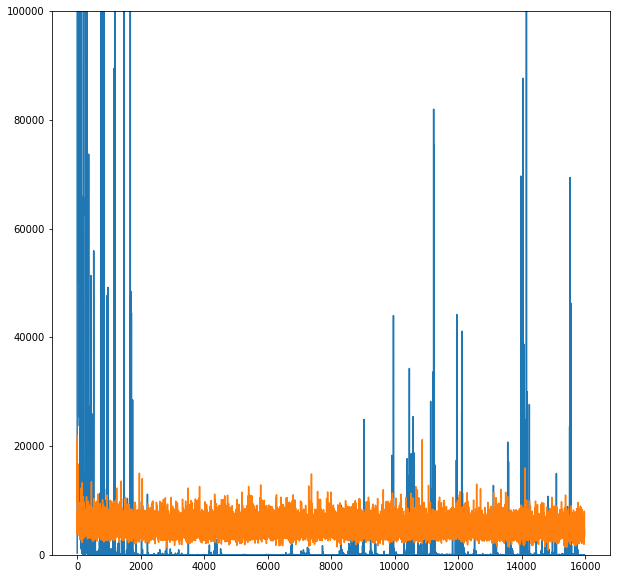

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.plot(encoder_losses)
axes.plot(decoder_losses)
plt.setp(axes, ylim=[0, 100000])


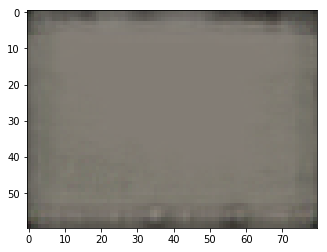

In [25]:
plt.imshow(predictions[-1][0, 0, :, :, :]/255)

In [17]:
def render_movie(frame_array, output_file, fps, max_pixel=255):
    n_frames = frame_array.shape[0]
    scaled_array = frame_array
    clipped_frames = np.minimum(np.maximum(scaled_array, 0), max_pixel).astype(np.uint8)
    clip = mpe.ImageSequenceClip(list(clipped_frames), fps=fps)
    clip.write_videofile(output_file)
    return clipped_frames

frame_array = render_movie(predictions[-1][0], 'test_lstm_pred.mp4', 5)

[MoviePy] >>>> Building video test_lstm_pred.mp4
[MoviePy] Writing video test_lstm_pred.mp4


100%|██████████| 64/64 [00:00<00:00, 2385.65it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_lstm_pred.mp4 



# Dated

In [4]:
def run_exp_ae(batchsize, num_epochs, data=None):
    
    if data is not None:
        video_inputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='inputs')
        video_outputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='outputs')
    else:
         video_inputs, video_outputs = load.inputs('training', batchsize, num_epochs)
            
    inputs = tf.reshape(video_inputs, (-1, 60, 80, 3))
    _, decoded_outputs = build_ae_model(video_inputs, encoder, decoder)

    decoded = tf.reshape(decoded_outputs, (-1, 64, 60, 80, 3))
    l2_weight = .02
    l2_vars = [v for v in tf.trainable_variables() if 'bias' not in v.name]
    l2_vars = [v for v in l2_vars if 'lstm' not in v.name]
    l2_term = tf.add_n([tf.nn.l2_loss(v) for v in l2_vars])
    
    loss = tf.reduce_mean(tf.pow(decoded - video_outputs, 2))
    train_step = tf.train.AdamOptimizer().minimize(loss + l2_weight*l2_term)
    
    saver = tf.train.Saver()
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    coord = tf.train.Coordinator()
        
    with tf.Session() as sesh:
        sesh.run(init_global)
        sesh.run(init_local)
        threads = tf.train.start_queue_runners(sess=sesh, coord=coord)

        losses = []
        predictions = []
        
        if data is not None:
            X = data[:, :-1, :, :, :]
            y = data[:, 1:, :, :, :]
            for epoch in range(num_epochs):
                batch_no = 0
                for X_batch, y_batch in iterate_minibatches(X, y, batchsize=batchsize, shuffle=True):
                    _, loss_value = sesh.run(
                        [train_step, loss], 
                        feed_dict={video_inputs: X_batch, video_outputs: y_batch}
                    )

                    losses.append(loss_value / batchsize)
                    if epoch % 10 == 0:
                        if batch_no == 0:
                            pred = sesh.run(decoded, feed_dict={video_inputs: X_batch, video_outputs: y_batch})
                            predictions.append(pred)

                print('Epoch {} loss: {:.8f}'.format(epoch, loss_value))
            
            saver.save(sesh, 'prototype-lstm-dummydata')
        
        else:
            try:
                step = 0

                while not coord.should_stop():
                    _, loss_value, prediction = sesh.run([train_step, loss, decoded])
                    losses.append(loss_value)

                    if step % 500 == 0:
                        print('Step {} loss:\t{:.8f}'.format(step, loss_value))
                        predictions.append(prediction)
                        
                    if step > 1000:
                        break
                    
                    step += 1

            except tf.errors.OutOfRangeError:
                print('Done; loss:\t{:.8f}'.format(loss_value))

            finally:
                coord.request_stop()

            coord.join(threads)
            saver.save(sesh, 'prototype-lstm')
        
    return losses, predictions

video_mask = np.ones((1024, 65, 3, 60, 80), dtype=np.uint8)
frame = np.eye(60, dtype=np.uint8)
padded = np.pad(frame, ((0, 0), (0, 20)), 'constant')

video = video_mask * padded
video = video.transpose((0, 1, 3, 4, 2))

losses, predictions = run_exp_ae(16, 3)

[1024, 54, 74, 32] 127872
Step 0 loss:	0.41123143
Step 500 loss:	0.19287437
Step 1000 loss:	0.20916134


In [6]:
losses = run_training(10, 4)

[256, 54, 74, 32] 127872
[256, 54, 74, 32] 127872
132.028131
Step 0 loss: 0.2349
Step 500 loss: 0.2951
Step 1000 loss: 0.2732
Step 1500 loss: 0.2971
Step 2000 loss: 0.3299
Step 2500 loss: 0.2013
Step 3000 loss: 0.2342
Step 3500 loss: 0.2449
Step 4000 loss: 0.2932
Step 4500 loss: 0.2911
Done; loss: 4997.0000


In [7]:
losses, predictions = run_inference(4, 1)

[256, 54, 74, 32] 127872
[256, 54, 74, 32] 127872
INFO:tensorflow:Restoring parameters from prototype-lstm
Step 0 loss: 1.0216
Step 100 loss: 5.1698
Step 200 loss: 3.0293
Step 300 loss: 3.5475
Step 400 loss: 6.0285
Done; loss: 499.0000


In [8]:
predictions[0][0].shape

(64, 60, 80, 3)

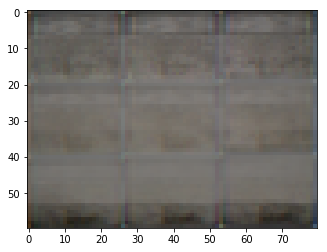

In [10]:
plt.imshow(frame_array[0])

In [7]:
def iterate_minibatches(inputs, targets, batchsize=32, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        idxs = np.arange(len(inputs))
        np.random.shuffle(idxs)

    for idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = idxs[idx:idx + batchsize]
        else:
            excerpt = slice(idx, idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def run_exp(batchsize, num_epochs, data):
    
    video_inputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='inputs')
    video_outputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='outputs')
    
    targets, predictions, decoded = build_model(
        video_inputs, video_outputs, 
        encoder, lstm_cell, decoder, 
        batchsize
    )

    l2_weight = .02
    l2_vars = [v for v in tf.trainable_variables() if 'bias' not in v.name]
    l2_vars = [v for v in l2_vars if 'lstm' not in v.name]
    l2_term = tf.add_n([tf.nn.l2_loss(v) for v in l2_vars])
    
    loss = tf.reduce_mean(tf.pow(decoded - video_outputs, 2))
    train_step = tf.train.AdamOptimizer().minimize(loss + l2_weight*l2_term)
    
    saver = tf.train.Saver()
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    coord = tf.train.Coordinator()
        
    with tf.Session() as sesh:
        sesh.run(init_global)
        sesh.run(init_local)
        threads = tf.train.start_queue_runners(sess=sesh, coord=coord)

        losses = []
        predictions = []
        X = data[:, :-1, :, :, :]
        y = data[:, 1:, :, :, :]
        for epoch in range(num_epochs):
            batch_no = 0
            for X_batch, y_batch in iterate_minibatches(X, y, batchsize=batchsize, shuffle=True):
                _, loss_value = sesh.run(
                    [train_step, loss], 
                    feed_dict={video_inputs: X_batch, video_outputs: y_batch}
                )
                
                losses.append(loss_value / batchsize)
                if epoch % 10 == 0:
                    if batch_no == 0:
                        pred = sesh.run(decoded, feed_dict={video_inputs: X_batch, video_outputs: y_batch})
                        predictions.append(pred)

            print('Epoch {} loss: {:.8f}'.format(epoch, loss_value))
            
        saver.save(sesh, 'prototype-lstm-dummydata')
        
    return losses, predictions

In [ ]:
video_mask = np.ones((1024, 65, 3, 60, 80), dtype=np.uint8)
frame = np.eye(60, dtype=np.uint8)
padded = np.pad(frame, ((0, 0), (0, 20)), 'constant')

video = video_mask * padded
video = video.transpose((0, 1, 3, 4, 2))

losses, predictions = run_exp(16, 31, video.astype(np.float32))

[None, 54, 74, 32] 127872
[None, 54, 74, 32] 127872
Epoch 0 loss: 0.00141136
Epoch 1 loss: 0.00137648
Epoch 2 loss: 0.00136667
Epoch 3 loss: 0.00107762
Epoch 4 loss: 0.00092498
Epoch 5 loss: 0.00074946
Epoch 6 loss: 0.00062873
Epoch 7 loss: 0.00058377
Epoch 8 loss: 0.00052654
Epoch 9 loss: 0.00052334
Epoch 10 loss: 0.00048500
Epoch 11 loss: 0.00045160
Epoch 12 loss: 0.00047589
Epoch 20 loss: 0.00037393
Epoch 21 loss: 0.00041242
Epoch 22 loss: 0.00048877
Epoch 23 loss: 0.00029773
Epoch 24 loss: 0.00036219
Epoch 25 loss: 0.00028578
Epoch 26 loss: 0.00024851
Epoch 27 loss: 0.00038165
Epoch 28 loss: 0.00110055
Epoch 29 loss: 0.02129955
Epoch 30 loss: 0.06080876


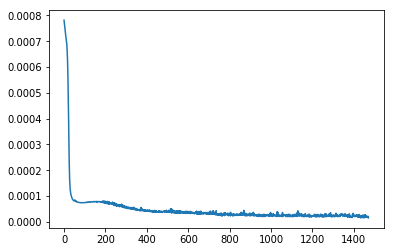

In [9]:
plt.plot(losses)

In [10]:
def render_movie(frame_array, output_file, fps, max_pixel=255):
    n_frames = frame_array.shape[0]
    scaled_array = frame_array * 127.5 + 127.5
    clipped_frames = np.minimum(np.maximum(scaled_array, 0), max_pixel).astype(np.uint8)
    clip = mpe.ImageSequenceClip(list(clipped_frames), fps=fps)
    clip.write_videofile(output_file)
    return clipped_frames

frame_array = render_movie(predictions[1][0], 'test_lstm_pred_dummy.mp4', 5)

[MoviePy] >>>> Building video test_lstm_pred_dummy.mp4
[MoviePy] Writing video test_lstm_pred_dummy.mp4


100%|██████████| 64/64 [00:00<00:00, 526.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_lstm_pred_dummy.mp4 



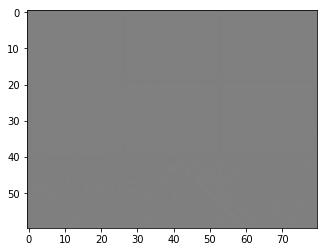

In [12]:
plt.imshow(frame_array[0])